In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, brentq
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from datetime import datetime, timedelta
from scipy.stats import norm, t, uniform, kendalltau, rankdata
import pyvinecopulib as pv
import ipywidgets as widgets
from ipywidgets import interact

### Data Generation

In [3]:
def generate_gaussian_copula(n_points, rho):
    """Generate samples from a Gaussian copula"""
    mean = [0, 0]
    cov = [[1, rho], [rho, 1]]
    Z = np.random.multivariate_normal(mean, cov, n_points)
    U = norm.cdf(Z)
    return U

def generate_clayton_copula(n_points, theta):
    """Generate samples from a Clayton copula"""
    if theta < 0:
        raise ValueError("theta must be >= 0")
        
    U1 = np.random.uniform(0, 1, n_points)
    q = np.random.uniform(0, 1, n_points)
    
    # Clayton copula generator
    U2 = U1 * (q**(-theta/(1 + theta)) - 1 + U1**theta)**(-1/theta)
    
    return np.column_stack((U1, U2))

def generate_gumbel_copula(n_points, theta):
    def gumbel_phi(t, alpha):
        return (-np.log(t))**alpha
    
    def gumbel_phi_inv(t, alpha):
        return np.exp(-t**(1/alpha))
    
    def gumbel_K(t, alpha):
        return t * (alpha - np.log(t)) / alpha
    
    # Generate uniform random variables
    t1 = np.random.rand(n_points)
    t2 = np.random.rand(n_points)
    
    # Find roots for each point
    w = []
    eps = 1e-10  # Small epsilon to avoid log(0)
    
    for t in t2:
        func = lambda w: gumbel_K(w, alpha=theta) - t
        w.append(brentq(func, eps, 1-eps))
    
    w = np.array(w).flatten()
    
    # Generate copula samples
    u = gumbel_phi_inv(t1 * gumbel_phi(w, alpha=theta), alpha=theta)
    v = gumbel_phi_inv((1-t1) * gumbel_phi(w, alpha=theta), alpha=theta)
    
    return np.vstack([u, v]).T

In [4]:
def generate_time_series(n_points, copula_type, param, marginal='normal', df=5):
    # Generate copula samples
    if copula_type == 'gaussian':
        U = generate_gaussian_copula(n_points, param)
    elif copula_type == 'clayton':
        U = generate_clayton_copula(n_points, param)
    elif copula_type == 'gumbel':
        U = generate_gumbel_copula(n_points, param)
    else:
        raise ValueError("Invalid copula type")
    
    # Transform to desired marginal distribution
    if marginal == 'normal':
        X = norm.ppf(U)
    elif marginal == 't':
        X = t.ppf(U, df)
    else:
        raise ValueError("Invalid marginal distribution")
    
    # Return the dependent sequence
    return X.flatten()


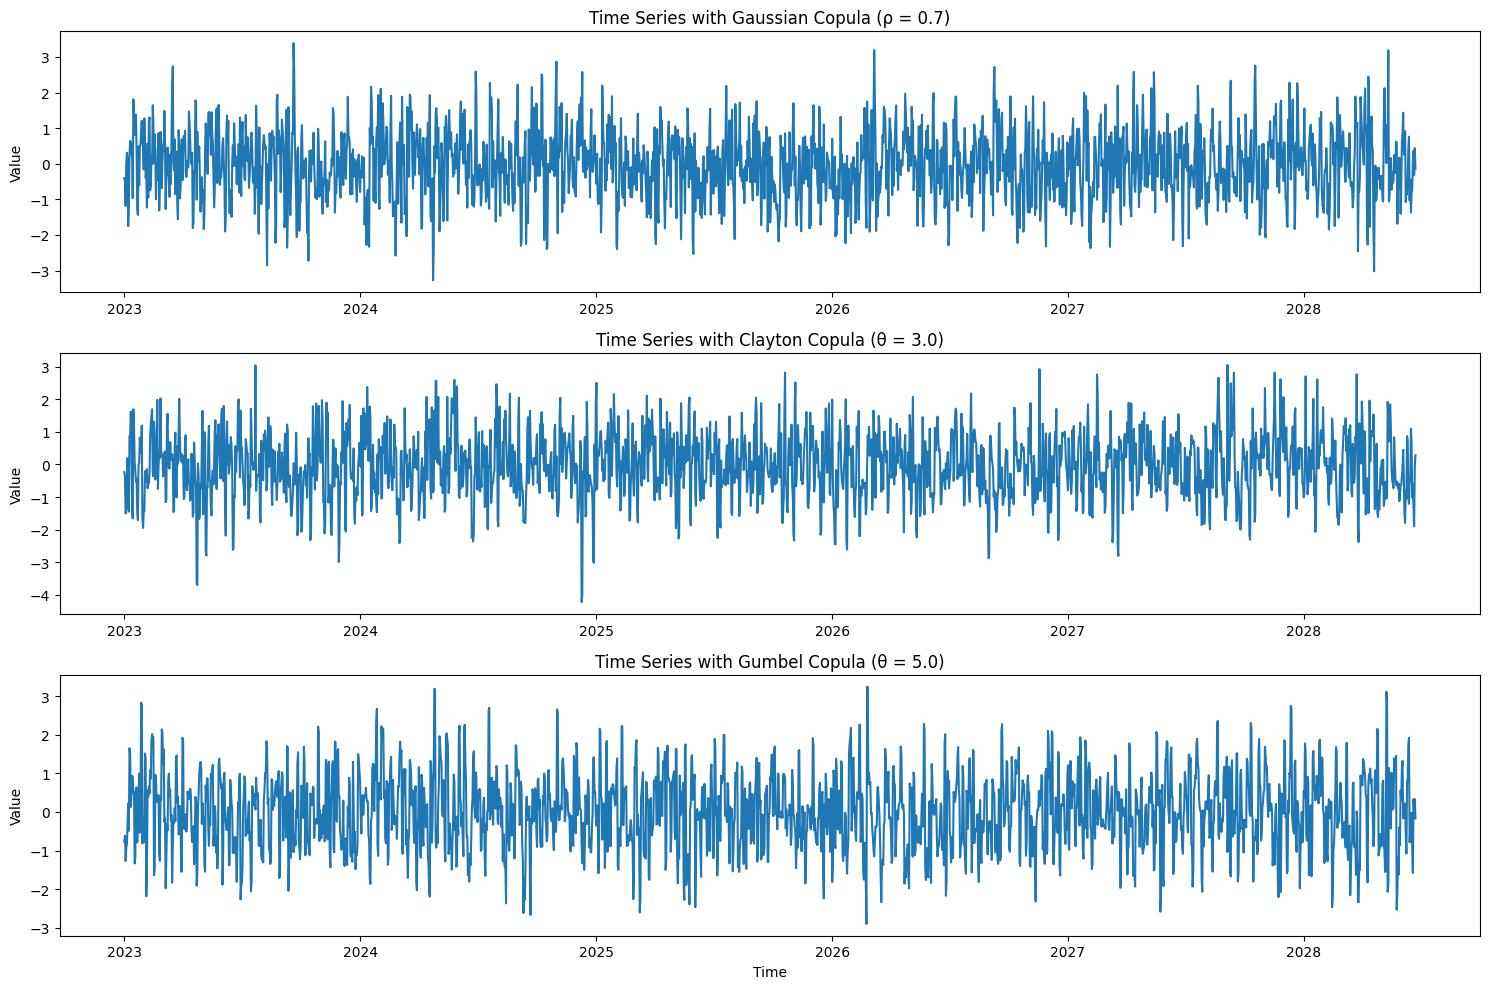

In [5]:
# Generate example time series
np.random.seed(42)
n_points = 1000
time_index = pd.date_range(start='2023-01-01', periods=n_points*2, freq='D')

# Generate three different time series
ts_gaussian = generate_time_series(n_points, 'gaussian', 0.7)
ts_clayton = generate_time_series(n_points, 'clayton', 3.0)
ts_gumbel = generate_time_series(n_points, 'gumbel', 5.0)

# Plot time series
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(time_index, ts_gaussian)
plt.title('Time Series with Gaussian Copula (ρ = 0.7)')
plt.ylabel('Value')

plt.subplot(3, 1, 2)
plt.plot(time_index, ts_clayton)
plt.title('Time Series with Clayton Copula (θ = 3.0)')
plt.ylabel('Value')

plt.subplot(3, 1, 3)
plt.plot(time_index, ts_gumbel)
plt.title('Time Series with Gumbel Copula (θ = 5.0)')
plt.ylabel('Value')
plt.xlabel('Time')

plt.tight_layout()
plt.show()

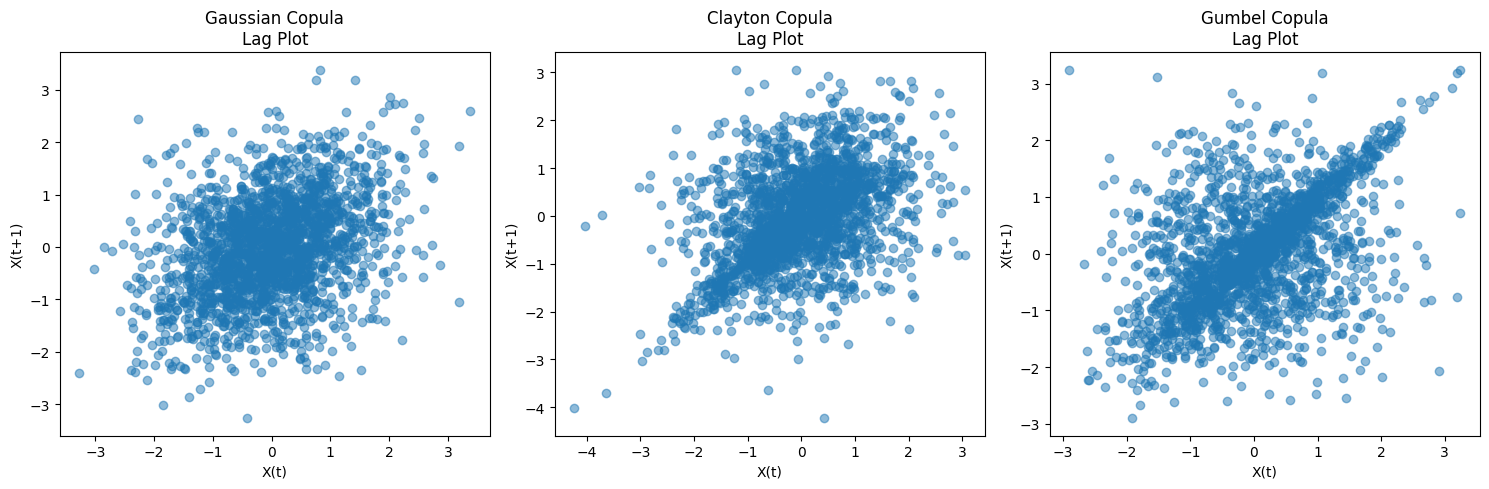

In [6]:
# Plot scatter plots (lag plots)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(ts_gaussian[:-1], ts_gaussian[1:], alpha=0.5)
plt.title('Gaussian Copula\nLag Plot')
plt.xlabel('X(t)')
plt.ylabel('X(t+1)')

plt.subplot(1, 3, 2)
plt.scatter(ts_clayton[:-1], ts_clayton[1:], alpha=0.5)
plt.title('Clayton Copula\nLag Plot')
plt.xlabel('X(t)')
plt.ylabel('X(t+1)')

plt.subplot(1, 3, 3)
plt.scatter(ts_gumbel[:-1], ts_gumbel[1:], alpha=0.5)
plt.title('Gumbel Copula\nLag Plot')
plt.xlabel('X(t)')
plt.ylabel('X(t+1)')

plt.tight_layout()
plt.show()

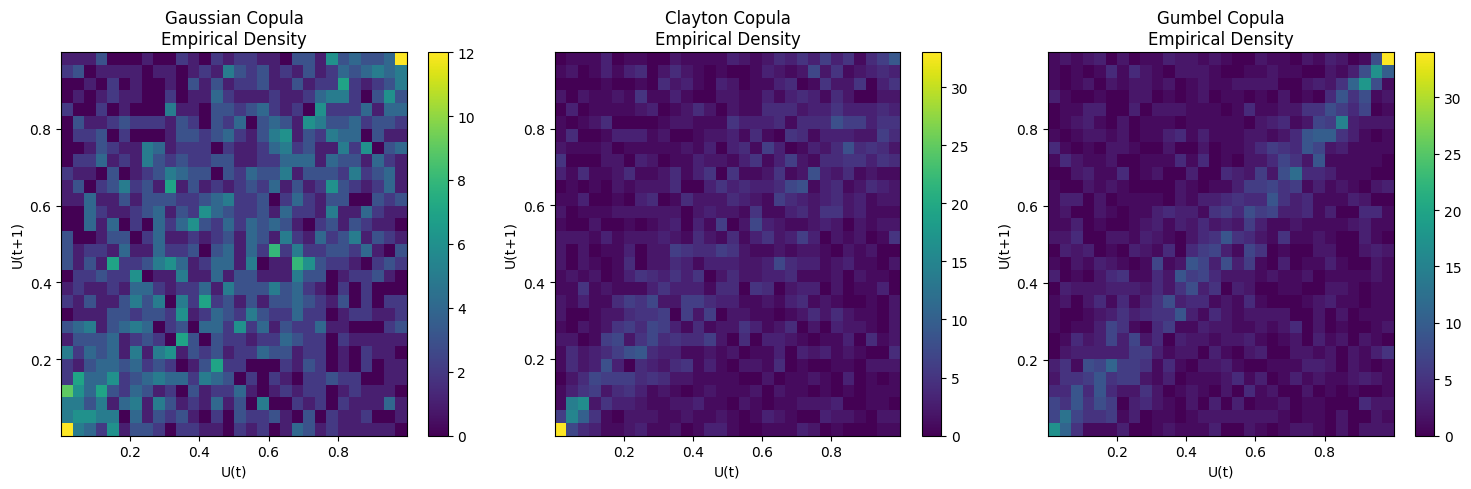

In [7]:
# Plot empirical copula densities
plt.figure(figsize=(15, 5))

for idx, (ts, title) in enumerate([(ts_gaussian, 'Gaussian'), 
                                 (ts_clayton, 'Clayton'), 
                                 (ts_gumbel, 'Gumbel')]):
    plt.subplot(1, 3, idx+1)
    
    # Transform to uniform marginals
    u1 = norm.cdf(ts[:-1])
    u2 = norm.cdf(ts[1:])
    
    # Create 2D histogram
    plt.hist2d(u1, u2, bins=30, cmap='viridis')
    plt.colorbar()
    plt.title(f'{title} Copula\nEmpirical Density')
    plt.xlabel('U(t)')
    plt.ylabel('U(t+1)')

plt.tight_layout()
plt.show()

### Parameter Estimation

Estimated marginal parameters (df, loc, scale): [ 6.24738289 -0.02202276  1.05507732]
True theta: 2.0
Estimated theta: 20.0


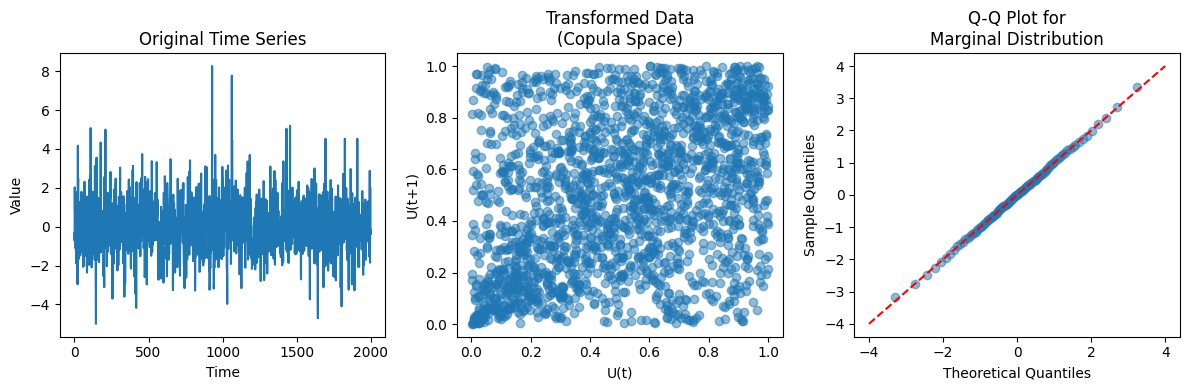

In [8]:
def estimate_marginal_params(data, dist='t'):
    """
    Estimate parameters for marginal distribution using MLE
    """
    if dist == 't':
        def neg_log_likelihood(params):
            df, loc, scale = params
            return -np.sum(t.logpdf(data, df=df, loc=loc, scale=scale))
        
        # Initial guess for parameters
        init_params = [5, np.mean(data), np.std(data)]
        
        # Optimize
        result = minimize(neg_log_likelihood, init_params, 
                        bounds=[(2.1, 30), (None, None), (0.01, None)])
        return result.x
    
    elif dist == 'normal':
        return np.mean(data), np.std(data)

def estimate_copula_params(u1, u2, copula_type='gaussian'):
    """
    Estimate copula parameters using maximum likelihood
    """
    if copula_type == 'gaussian':
        # For Gaussian copula, we can use correlation
        return np.corrcoef(norm.ppf(u1), norm.ppf(u2))[0,1]
    
    elif copula_type == 'clayton':
        def neg_log_likelihood(theta):
            # Clayton copula log-likelihood
            if theta <= 0:
                return np.inf
            return -np.sum(np.log(1 + theta) - (theta + 1) * 
                          np.log(u1) - (theta + 1) * np.log(u2) + 
                          (1 + 2*theta) * np.log(u1**(-theta) + u2**(-theta) - 1))
        
        result = minimize(neg_log_likelihood, x0=[1.0], bounds=[(0.01, 20)])
        return result.x[0]

# Example usage with simulated data
np.random.seed(42)
n_points = 1000
true_theta = 2.0

# Generate some sample data with t-distributed margins and Clayton copula
data = generate_time_series(n_points, 'clayton', true_theta, 't')

# Step 1: Estimate marginal parameters
marginal_params = estimate_marginal_params(data, dist='t')
print("Estimated marginal parameters (df, loc, scale):", marginal_params)

# Step 2: Transform to uniform using estimated parameters
u = t.cdf(data, df=marginal_params[0], loc=marginal_params[1], scale=marginal_params[2])

# Step 3: Estimate copula parameter
u1 = u[:-1]  # Lagged values
u2 = u[1:]   # Current values
theta_est = estimate_copula_params(u1, u2, copula_type='clayton')
print(f"True theta: {true_theta}")
print(f"Estimated theta: {theta_est}")

# Plot results
plt.figure(figsize=(12, 4))

# Original data
plt.subplot(1, 3, 1)
plt.plot(data)
plt.title('Original Time Series')
plt.xlabel('Time')
plt.ylabel('Value')

# Transformed data
plt.subplot(1, 3, 2)
plt.scatter(u1, u2, alpha=0.5)
plt.title('Transformed Data\n(Copula Space)')
plt.xlabel('U(t)')
plt.ylabel('U(t+1)')

# QQ plot for marginal fit
plt.subplot(1, 3, 3)
theoretical_quantiles = t.ppf(np.linspace(0.01, 0.99, 100), 
                            df=marginal_params[0], 
                            loc=marginal_params[1], 
                            scale=marginal_params[2])
empirical_quantiles = np.percentile(data, np.linspace(1, 99, 100))
plt.scatter(theoretical_quantiles, empirical_quantiles, alpha=0.5)
plt.plot([-4, 4], [-4, 4], 'r--')
plt.title('Q-Q Plot for\nMarginal Distribution')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

plt.tight_layout()
plt.show()

### Practical Example

In [9]:
from meteostat import Point, Daily
from datetime import datetime
import pandas as pd

location = Point(35.6833, -117.7000)

def get_china_lake_tempdata(start_year=2010, end_year=2023):
    # Get daily data
    data = Daily(location,
                 start=datetime(start_year, 1, 1),
                 end=datetime(end_year, 12, 31))
    df = data.fetch()
    return df[['tmax']].rename(columns={'tmax': 'max_temp'})

df = get_china_lake_tempdata(start_year=2021, end_year=2023)

<Axes: xlabel='time'>

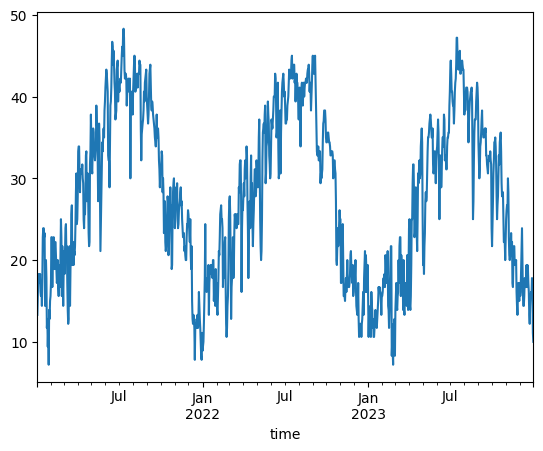

In [10]:
df['max_temp'].interpolate().plot()

<Axes: >

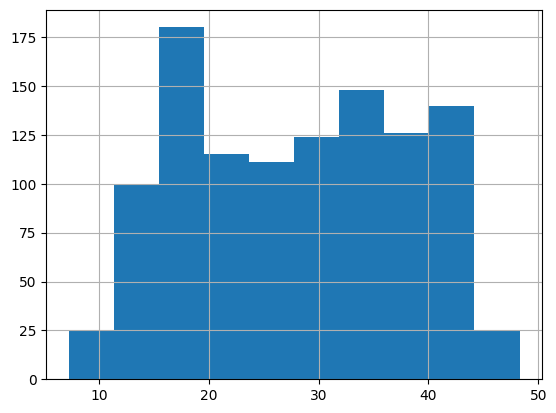

In [11]:
df['max_temp'].interpolate().hist()

<Axes: >

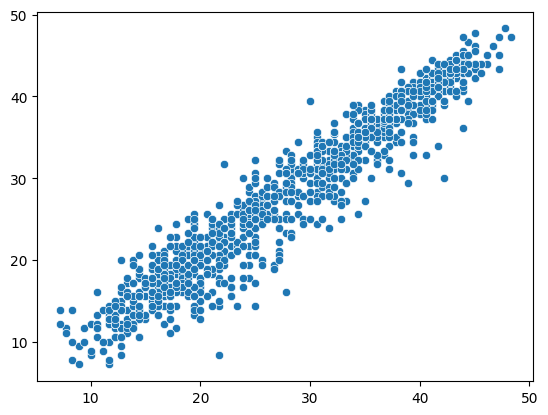

In [12]:
sns.scatterplot(x=df['max_temp'].interpolate().values[:-1], y=df['max_temp'].interpolate().values[1:])

In [13]:
from scipy.stats import kendalltau, pearsonr
def analyze_dependence(temps):
    """Analyze temporal dependence in temperature series"""
    temp_t = temps[:-1]
    temp_t1 = temps[1:]
    
    pearson_corr, _ = pearsonr(temp_t, temp_t1)
    kendall_tau, _ = kendalltau(temp_t, temp_t1)
    print(pearsonr(temp_t, temp_t1))
    print(kendalltau(temp_t, temp_t1))
    
    lower_tail = []
    upper_tail = []
    
    for alpha in [0.05, 0.1, 0.15]:
        # Lower tail - using numpy logical_or
        lower = np.mean(np.logical_or(
            temp_t1 <= np.quantile(temp_t1, alpha),
            temp_t <= np.quantile(temp_t, alpha)
        ))
        lower_tail.append(lower)
        
        # Upper tail
        upper = np.mean(np.logical_or(
            temp_t1 >= np.quantile(temp_t1, 1-alpha),
            temp_t >= np.quantile(temp_t, 1-alpha)
        ))
        upper_tail.append(upper)
    
    return {
        'pearson': pearson_corr,
        'kendall': kendall_tau,
        'lower_tail': lower_tail,
        'upper_tail': upper_tail,
        'temp_t': temp_t,
        'temp_t1': temp_t1
    }

In [14]:
dependence_info = analyze_dependence(df['max_temp'].interpolate().values)
dependence_info

PearsonRResult(statistic=np.float64(0.9634166940438618), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.8451170856072165), pvalue=np.float64(0.0))


{'pearson': np.float64(0.9634166940438618),
 'kendall': np.float64(0.8451170856072165),
 'lower_tail': [np.float64(0.07868252516010979),
  np.float64(0.1344922232387923),
  np.float64(0.19762122598353157)],
 'upper_tail': [np.float64(0.0686184812442818),
  np.float64(0.13632204940530648),
  np.float64(0.1747483989021043)],
 'temp_t': array([13.3, 15.6, 17.8, ..., 17.8, 17.2, 11.1], shape=(1093,)),
 'temp_t1': array([15.6, 17.8, 18.3, ..., 17.2, 11.1, 10. ], shape=(1093,))}

In [15]:
# fit a copula to the data
from scipy.optimize import fsolve
import scipy.integrate as integrate

def fit_copulas(temp_t, temp_t1, tau):
    """Fit copulas using inverse Kendall's tau method"""
    # Gaussian copula parameter
    rho_gaussian = np.sin(np.pi * tau / 2)
    
    # Clayton copula parameter
    theta_clayton = 2.0*tau/(1.0-tau)
    
    # Gumbel copula parameter
    theta_gumbel = 1 / (1 - tau)

    def debye(x, n):
        """
        Evaluate the Debye function.
        See http://en.wikipedia.org/wiki/Debye_function for details
        """
        # ensure n is a float
        n = float(n)
        
        sol = integrate.quad( lambda t: pow(t,n)/(np.exp(t)-1.0) , 0.0, x)
        return n*sol[0]/pow(x,n)

    def _frank_kendall_fopt(alpha, tau):
        return 4*( debye(alpha,1) - 1 )/alpha + 1 - tau

    theta_frank = fsolve(_frank_kendall_fopt, 1, args=(tau))[0]
    return {
        'gaussian': rho_gaussian,
        'clayton': theta_clayton,
        'gumbel': theta_gumbel,
        'frank': theta_frank
    }

def gumbel_phi(t, alpha):
    return (-np.log(t))**alpha

def gumbel_phi_inv(t, alpha):
    return np.exp(-t**(1/alpha))

def gumbel_K(t, alpha):
    return t * (alpha - np.log(t)) / alpha

def frank_phi(t, alpha):
    return -np.log((np.exp(-alpha*t) - 1) / (np.exp(-alpha) - 1))

def frank_phi_inv(t, alpha):
    return -1/alpha * np.log((np.exp(-alpha) - 1) / np.exp(t) + 1)

def frank_K(t, alpha):
    return (t + (1 - np.exp(alpha*t)) * np.log((1-np.exp(alpha*t)) * 
                                               np.exp(-alpha*t+alpha) / (1-np.exp(alpha))) / alpha)
def plot_dependencies(temp_t, temp_t1, params):
    """Create visualization of empirical vs fitted copulas"""
    # Convert to pseudo-observations
    u = stats.rankdata(temp_t) / (len(temp_t) + 1)
    v = stats.rankdata(temp_t1) / (len(temp_t1) + 1)
    
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))
    
    # Empirical scatter
    # Generate from fitted copulas
    n = len(temp_t)
    
    # Gaussian
    rho = params['gaussian']
    gaussian_sample = np.random.multivariate_normal([0,0], [[1, rho], [rho, 1]], n)
    gaussian_u = stats.norm.cdf(gaussian_sample[:,0])
    gaussian_v = stats.norm.cdf(gaussian_sample[:,1])
    sns.scatterplot(x=gaussian_u, y=gaussian_v, alpha=0.5, ax=axes[0,0])
    sns.scatterplot(x=u, y=v, alpha=0.5, ax=axes[0,0], color='black', marker='.')
    axes[0,0].set_title(f'Gaussian (ρ={rho:.2f})')
    
    # Clayton
    theta_c = params['clayton']
    uniform = np.random.uniform(0, 1, (n, 2))
    t = np.random.gamma(1/theta_c, scale=1, size=n)
    clayton_u = (1 + t * (-np.log(uniform[:,0])))**(-1/theta_c)
    clayton_v = (1 + t * (-np.log(uniform[:,1])))**(-1/theta_c)
    sns.scatterplot(x=clayton_u, y=clayton_v, alpha=0.5, ax=axes[0,1])
    sns.scatterplot(x=u, y=v, alpha=0.5, ax=axes[0,1], color='black', marker='.')
    axes[0,1].set_title(f'Clayton (θ={theta_c:.2f})')
    
    # Gumbel
    alpha = params['gumbel']
    t1 = np.random.rand(n)
    t2 = np.random.rand(n)
    w = []
    for t in t2:
        func = lambda w: gumbel_K(w, alpha=alpha) - t
        w.append(brentq(func, 0.0000000001, 0.9999999999))
    w = np.array(w).flatten()
    u = gumbel_phi_inv(t1 * gumbel_phi(w, alpha=alpha), alpha=alpha)
    v = gumbel_phi_inv((1-t1) * gumbel_phi(w, alpha=alpha), alpha=alpha)
    sns.scatterplot(x=u, y=v, alpha=0.5, ax=axes[1,0])
    sns.scatterplot(x=u, y=v, alpha=0.5, ax=axes[1,0], color='black', marker='.')    
    axes[1,0].set_title(f'Gumbel (θ={alpha:.2f})')

    # Frank
    alpha = params['frank']
    t1 = np.random.rand(n)
    t2 = np.random.rand(n)

    w = []
    for t in t2:
        func = lambda w: frank_K(w, alpha=alpha) - t
        w.append(brentq(func, 0.0000000001, 0.9999999999))
    w = np.array(w).flatten()

    u = frank_phi_inv(t1 * frank_phi(w, alpha=alpha), alpha=alpha)
    v = frank_phi_inv((1-t1) * frank_phi(w, alpha=alpha), alpha=alpha)
    sns.scatterplot(x=u, y=v, alpha=0.5, ax=axes[1,1])
    sns.scatterplot(x=u, y=v, alpha=0.5, ax=axes[1,1], color='black', marker='.')
    axes[1,1].set_title(f'Frank (θ={alpha:.2f})')
    
    plt.tight_layout()
    return fig

Fitted parameters: {'gaussian': np.float64(0.9705507950109324), 'clayton': np.float64(10.912980155629013), 'gumbel': np.float64(6.4564900778145065), 'frank': np.float64(24.06031412378537)}


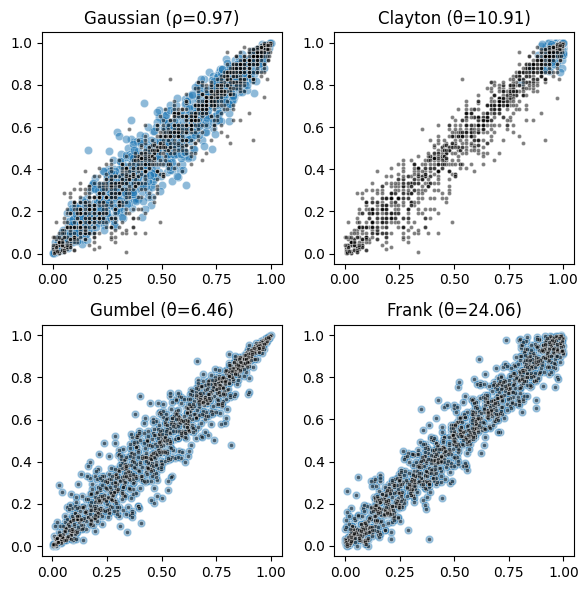

In [16]:
params = fit_copulas(dependence_info['temp_t'], dependence_info['temp_t1'], dependence_info['kendall'])
fig = plot_dependencies(dependence_info['temp_t'], dependence_info['temp_t1'], params)
print("Fitted parameters:", params)
plt.show()

In [17]:
def compute_gof(u, v, params):
    """Compute Cramér-von Mises statistic for each copula"""
    n = len(u)
    gof_stats = {}
    
    # Gaussian
    rho = params['gaussian']
    gaussian_cvm = np.sum((stats.norm.cdf(stats.norm.ppf(v), 
                                        loc=rho*stats.norm.ppf(u),
                                        scale=np.sqrt(1-rho**2)) - v)**2)
    
    # Clayton
    theta = params['clayton']
    clayton_cvm = np.sum((np.power(np.power(u, -theta) + np.power(v, -theta) - 1, -1/theta) - v)**2)
    
    # Gumbel
    theta = params['gumbel']
    gumbel_cvm = np.sum((np.exp(-np.power(np.power(-np.log(u), theta) + 
                                         np.power(-np.log(v), theta), 1/theta)) - v)**2)
    
    # Frank
    theta = params['frank']
    frank_cvm = np.sum((-1/theta * np.log(1 + (np.exp(-theta*u) - 1) * 
                                         (np.exp(-theta*v) - 1)/(np.exp(-theta) - 1)) - v)**2)
    
    return {
        'gaussian': gaussian_cvm/n,
        'clayton': clayton_cvm/n,
        'gumbel': gumbel_cvm/n,
        'frank': frank_cvm/n
    }

u = stats.rankdata(dependence_info['temp_t']) / (len(dependence_info['temp_t']) + 1)
v = stats.rankdata(dependence_info['temp_t1']) / (len(dependence_info['temp_t1']) + 1)
gof_stats = compute_gof(u, v, params)
gof_stats

{'gaussian': np.float64(0.1382013646969156),
 'clayton': np.float64(0.0034475937206485583),
 'gumbel': np.float64(0.0033335718603882416),
 'frank': np.float64(0.003230594649426233)}

In [18]:
best_copula = min(gof_stats, key=gof_stats.get)
print(best_copula)
best_copula_params = params[best_copula]
print(best_copula_params)

frank
24.06031412378537


In [19]:
def sample_conditional_v(bicop, u_value, n_samples=1000):
    """
    Draw n_samples from the conditional distribution V|U = u_value
    using pyvinecopulib.Bicop's hinv1() method.

    Parameters
    ----------
    bicop : pyvinecopulib.Bicop
        A fitted Bicop object (bivariate).
    u_value : float in (0,1)
        The fixed value of U in [0,1].
    n_samples : int
        Number of conditional samples to generate.

    Returns
    -------
    v : np.ndarray of shape (n_samples,)
        Random draws from V|U=u_value, each in [0,1].
    """
    # 1. Generate uniform(0,1) draws for the inverse transform
    z = np.random.rand(n_samples).reshape(-1, 1)  # shape (n_samples, 1)

    # 2. Make an n x 2 array: first column = z, second column = u_value
    #    Because hinv1() expects [cdf_of_V|U=u, given_U]
    data_in = np.column_stack([z, np.full_like(z, fill_value=u_value)])

    # 3. Apply hinv1: shape will be (n_samples, 1)
    v_array = bicop.hinv1(data_in)

    return v_array.flatten()


In [20]:
def plot_conditional_distribution(temp_data, current_temp, copulas_dict, n_samples=10000):
    """Plot conditional distribution for multiple copulas"""
    # Transform current_temp to uniform scale
    u = ((temp_data <= current_temp).sum()) / (len(temp_data) + 1)
    n_copulas = len(copulas_dict)
    n_rows = (n_copulas + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(8, 6))
    axes = axes.flatten() if n_copulas > 1 else [axes]
    
    for (copula, copula_params), ax in zip(copulas_dict.items(), axes):
        if copula == 'gaussian':
            rho = copula_params
            bicop_gaussian = pv.Bicop(family=pv.BicopFamily.gaussian, parameters=[[rho]])
            conditional_v = sample_conditional_v(bicop_gaussian, u, n_samples)
        
        elif copula == 'clayton':
            theta = copula_params
            bicop_clayton = pv.Bicop(family=pv.BicopFamily.clayton, parameters=[[theta]])
            conditional_v = sample_conditional_v(bicop_clayton, u, n_samples)
        
        elif copula == 'gumbel':
            alpha = copula_params
            bicop_gumbel = pv.Bicop(family=pv.BicopFamily.gumbel, parameters=[[alpha]])
            conditional_v = sample_conditional_v(bicop_gumbel, u, n_samples)
        
        elif copula == 'frank':
            alpha = copula_params
            bicop_frank = pv.Bicop(family=pv.BicopFamily.frank, parameters=[[alpha]])
            conditional_v = sample_conditional_v(bicop_frank, u, n_samples)
        
        # Transform conditional samples to temperature scale
        temp_samples = np.quantile(temp_data, conditional_v)
        
        sns.kdeplot(data=temp_samples, ax=ax)
        ax.axvline(current_temp, color='r', linestyle='--', label=f'Current Temperature ({current_temp}°C)')
        
        percentiles = [5, 25, 50, 75, 95]
        temp_percentiles = np.percentile(temp_samples, percentiles)
        
        for p, t in zip(percentiles, temp_percentiles):
            ax.axvline(t, color='g', alpha=0.3, linestyle=':')
            ax.text(t, ax.get_ylim()[1], f'{p}%', rotation=90, va='top')
        
        ax.set_title(f'{copula.capitalize()} Copula (param={copula_params:.2f})')
        ax.set_xlabel('Temperature (°C)')
        ax.set_ylabel('Density')
    
    plt.suptitle(f'Conditional Distribution of Temperature at {current_temp}°C')

    plt.tight_layout()
    plt.show()

In [21]:
# Create slider widget
interact(
    lambda current_temp: plot_conditional_distribution(dependence_info['temp_t'], current_temp, params),
    current_temp=widgets.FloatSlider(
        value=25.0,
        min=10.0,
        max=40.0,
        step=0.5,
        description='Current Temp (°C)',
        continuous_update=False
    )
)

interactive(children=(FloatSlider(value=25.0, continuous_update=False, description='Current Temp (°C)', max=40…

<function __main__.<lambda>(current_temp)>